In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import re
import pyLDAvis
import pyLDAvis.gensim
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
import spacy
import en_core_web_sm
from spacy import displacy

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import svm
from sklearn import metrics
from sklearn import naive_bayes
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
data = pd.read_csv('data job posts.csv')
data.head()

jobpost          date  \
0  AMERIA Investment Consulting Company\r\nJOB TI...   Jan 5, 2004   
1  International Research & Exchanges Board (IREX...   Jan 7, 2004   
2  Caucasus Environmental NGO Network (CENN)\r\nJ...   Jan 7, 2004   
3  Manoff Group\r\nJOB TITLE:  BCC Specialist\r\n...   Jan 7, 2004   
4  Yerevan Brandy Company\r\nJOB TITLE:  Software...  Jan 10, 2004   

                                               Title  \
0                            Chief Financial Officer   
1  Full-time Community Connections Intern (paid i...   
2                                Country Coordinator   
3                                     BCC Specialist   
4                                 Software Developer   

                                           Company AnnouncementCode Term  \
0             AMERIA Investment Consulting Company              NaN  NaN   
1  International Research & Exchanges Board (IREX)              NaN  NaN   
2        Caucasus Environmental NGO Network (CENN)              NaN  NaN   
3                                     Manoff Group              NaN  NaN   
4                           Yerevan Brandy Company              NaN  NaN   

  Eligibility Audience StartDate                               Duration  \
0         NaN      NaN       NaN                                    NaN   
1         NaN      NaN       NaN                               3 months   
2         NaN      NaN       NaN  Renewable annual contract\r\nPOSITION   
3         NaN      NaN       NaN                                    NaN   
4         NaN      NaN       NaN                                    NaN   

   ...   Salary                                       ApplicationP  \
0  ...      NaN  To apply for this position, please submit a\r\...   
1  ...      NaN  Please submit a cover letter and resume to:\r\...   
2  ...      NaN  Please send resume or CV toursula.kazarian@......   
3  ...      NaN  Please send cover letter and resume to Amy\r\n...   
4  ...      NaN  Successful candidates should submit\r\n- CV; \...   

  OpeningDate                                       Deadline Notes  \
0         NaN                                26 January 2004   NaN   
1         NaN                                12 January 2004   NaN   
2         NaN  20 January 2004\r\nSTART DATE:  February 2004   NaN   
3         NaN      23 January 2004\r\nSTART DATE:  Immediate   NaN   
4         NaN                         20 January 2004, 18:00   NaN   

                                              AboutC Attach  Year Month     IT  
0                                                NaN    NaN  2004     1  False  
1  The International Research & Exchanges Board (...    NaN  2004     1  False  
2  The Caucasus Environmental NGO Network is a\r\...    NaN  2004     1  False  
3                                                NaN    NaN  2004     1  False  
4                                                NaN    NaN  2004     1   True  

[5 rows x 24 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             19001 non-null object
date                19001 non-null object
Title               18973 non-null object
Company             18994 non-null object
AnnouncementCode    1208 non-null object
Term                7676 non-null object
Eligibility         4930 non-null object
Audience            640 non-null object
StartDate           9675 non-null object
Duration            10798 non-null object
Location            18969 non-null object
JobDescription      15109 non-null object
JobRequirment       16479 non-null object
RequiredQual        18517 non-null object
Salary              9622 non-null object
ApplicationP        18941 non-null object
OpeningDate         18295 non-null object
Deadline            18936 non-null object
Notes               2211 non-null object
AboutC              12470 non-null object
Attach              1559 non-null object
Year              

#### Data Exploration

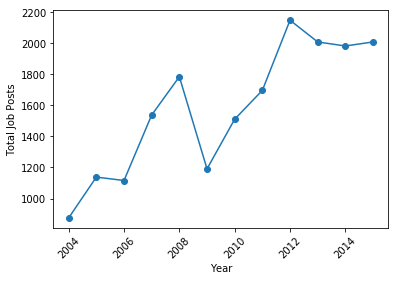

In [4]:
df1 = data.groupby(by=['Year'])[['jobpost']].count().reset_index()
plt.plot(df1['Year'],df1['jobpost'],marker='o')
plt.xlabel('Year')
plt.ylabel('Total Job Posts')
plt.xticks(rotation=45)
plt.show()

The number of job posts show increasing trend over the years.
There is slight dip in 2009 because of recession in 2008.

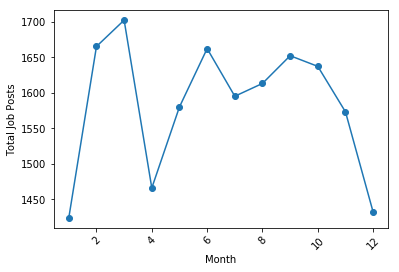

In [5]:
df2 = data.groupby(by=['Month'])[['jobpost']].count().reset_index()
plt.plot(df2['Month'],df2['jobpost'],marker='o')
plt.xlabel('Month')
plt.ylabel('Total Job Posts')
plt.xticks(rotation=45)
plt.show()

The number of jobs tends to be more in the months of March and June. Jobs are less in the month of December and January.

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


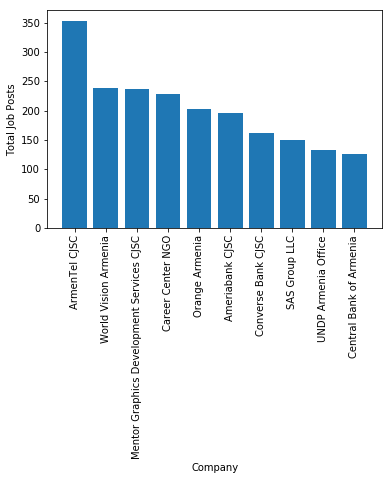

In [6]:
df3 = data.groupby(by=['Company'])[['jobpost']].count().reset_index().sort_index(by=['jobpost'],ascending=False).head(10)
plt.bar(df3['Company'],df3['jobpost'])
plt.xlabel('Company')
plt.ylabel('Total Job Posts')
plt.xticks(rotation=90)
plt.show()

These are the top 10 companies who had most number of job postings during this span.

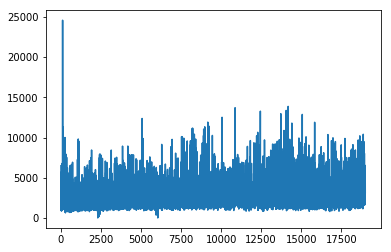

In [7]:
data['length_jobpost'] = data.jobpost.apply(lambda x: len(x))
plt.plot(data.index, data.length_jobpost)
plt.show()

In [8]:
data.sort_values('length_jobpost',ascending=False)

jobpost             date  \
105    USAID, DCHA and LWVF\r\nTITLE:   Annual Progra...      Mar 4, 2004   
14186  UNIDO - United Nations Industrial Development ...     Jul 29, 2013   
10873  Save the Children Federation Inc. Armenia Coun...     Jan 11, 2012   
14060  World Vision Armenia\r\nTITLE:  Program Direct...      Jul 3, 2013   
12450  UNDP Armenia Office\r\nTITLE:  Finance Officer...     Sep 27, 2012   
12446  UNDP Armenia Office\r\nTITLE:  Expert on IT an...     Sep 27, 2012   
13726  The World Bank\r\nTITLE:  Executive Assistant\...      May 2, 2013   
15067  World Vision Georgia\r\nTITLE:  Program Direct...     Jan 16, 2014   
10060  UNHCR Armenia Office\r\nTITLE:  United Nations...     Jul 12, 2011   
5069   OSCE Office in Yerevan\r\nTITLE:  Consultant(s...     Mar 21, 2008   
9168   UNDP Armenia Office\r\nTITLE:  National Expert...     Jan 11, 2011   
15840  The World Bank Yerevan Office\r\nTITLE:  Senio...     May 22, 2014   
14417  "FINCA" UCO\r\nTITLE:  HR Manager\r\nLOCATION:...     Sep 13, 2013   
106    ONCE, Spain\r\nTITLE:   International Prize fo...      Mar 4, 2004   
9238   Asian Development Bank (ADB), RETA6445 Support...     Jan 23, 2011   
8980   Asian Development Bank (ADB), RETA6445 Support...     Nov 18, 2010   
130    USAID/Armenia\r\nJOB TITLE:   Project Developm...     Mar 18, 2004   
12448  UNDP Armenia Office\r\nTITLE:  Administrative ...     Sep 27, 2012   
8227   UNDP Armenia Office\r\nTITLE:  Project Website...     May 21, 2010   
8198   UNDP Armenia Office\r\nTITLE:  Project Website...     May 24, 2010   
8914   Peace Corps Armenia\r\nTITLE:  Region Managers...      Nov 3, 2010   
13929  UNICEF Armenia\r\nTITLE:  Communcation Officer...    Jun 7 6:32 AM   
12286  UNDP Armenia Office\r\nTITLE:  National Projec...      Sep 3, 2012   
14092  WWF Armenia\r\nTITLE:  Project Coordinator\r\n...      Jul 9, 2013   
8329   UNDP Armenia Office\r\nTITLE:  SCIBM Local IT ...  Jun 22 12:32 AM   
18874  World Vision Armenia\r\n\r\n\r\nTITLE:  Lori M...      Dec 4, 2015   
16667  City-Mobil LLC\r\nTITLE:  Chief Technology Off...     Oct 28, 2014   
12449  UNDP Armenia Office\r\nTITLE:  Road Infrastruc...     Sep 27, 2012   
9454   Project Harmony Inc.\r\nTITLE:  ZANG Armenia L...      Mar 7, 2011   
8902   Regional Environmental Center for the Caucasus...      Nov 1, 2010   
...                                                  ...              ...   
17360  RTM LLC\r\nTITLE:  Sales Manager\r\nTERM:  Fre...           Mar 10   
2645   Neo Computer Technologies\r\nTITLE:  Sales Man...     Jul 19, 2006   
246    CIT Ltd\r\nTITLE:  Network Administrator\r\nTE...      May 4, 2004   
410    French University of Armenia\r\nTITLE:  Lectur...      Jul 9, 2004   
794    Firmplace Corporation\r\nTITLE:  Database Deve...      Dec 5, 2004   
15505  Westtrans LLC\r\nTITLE:  Transport Manager\r\n...     Mar 25, 2014   
408    French University of Armenia\r\nTITLE:  Lectur...      Jul 9, 2004   
409    French University of Armenia\r\nTITLE:  Lectur...      Jul 9, 2004   
407    French University of Armenia\r\nTITLE:  Lectur...      Jul 9, 2004   
411    French University in Armenia\r\nTITLE:  Lectur...      Jul 9, 2004   
412    French University of Armenia\r\nTITLE:  Lectur...      Jul 9, 2004   
16783  Brand Leader JV LLC\r\nTITLE:  Head Bookkepeer...     Nov 18, 2014   
1780   "A.B." LLC\r\nTITLE:  Pharmacist\r\nLOCATION: ...     Sep 28, 2005   
595    Private\r\nTITLE:  Nanny\r\nTERM:  Full-time\r...     Sep 20, 2004   
661    Manet Tiles\r\nTITLE:  Grafik /Interior & Exte...     Oct 12, 2004   
1069   3A&M Logic\r\nTITLE:  PHP Programmer\r\nLOCATI...     Feb 23, 2005   
561    Sada Systems\r\nTITLE:  Web designer\r\nLOCATI...      Sep 7, 2004   
239    ASPO (Armenian Software Project Outsource)\r\n...     Apr 29, 2004   
1070   3A&M Logic\r\nTITLE:  Flasher\r\nLOCATION:  Ye...     Feb 23, 2005   
482    "Union Lingua" Educational Center\r\nTITLE:  E...      Aug 1, 2004   
654    Private\r\nTITLE:  Private Violin Clas

In [9]:
print(data.iloc[105].Title)

Annual Program Statement: Implementation and Extension of


Job post with title 'Annual Program Statement: Implementation and Extension of' has the most length

#### Data Preperation

In [10]:
data.columns

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT', 'length_jobpost'],
      dtype='object')

In [11]:
cols = ['jobpost',
       'Title',
       'JobRequirment',
       'JobDescription',
       'RequiredQual',
       'AboutC',
       'IT',
       'Year']

The above columns are used for analysis

##### Data Cleaning

In [12]:
df = data[cols]
df = df.drop_duplicates(subset=['jobpost','Title'],keep='first')
df.shape

(18892, 8)

After identifying the duplicate rows based on 'jobpost' and 'Title' 109 rows were removed.

###### Removal of Newlines and single Quotes

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18892 entries, 0 to 19000
Data columns (total 8 columns):
jobpost           18892 non-null object
Title             18865 non-null object
JobRequirment     16429 non-null object
JobDescription    15059 non-null object
RequiredQual      18458 non-null object
AboutC            12377 non-null object
IT                18892 non-null bool
Year              18892 non-null int64
dtypes: bool(1), int64(1), object(6)
memory usage: 1.2+ MB


In [14]:
def cleanText(doc):
    doc = doc.replace("\n"," ")
    doc = doc.replace("'","")
    return(doc)

In [15]:
for col in df.columns.difference(['Year','IT']):
    df[col] = df[col].fillna("")
df.head()

jobpost  \
0  AMERIA Investment Consulting Company\r\nJOB TI...   
1  International Research & Exchanges Board (IREX...   
2  Caucasus Environmental NGO Network (CENN)\r\nJ...   
3  Manoff Group\r\nJOB TITLE:  BCC Specialist\r\n...   
4  Yerevan Brandy Company\r\nJOB TITLE:  Software...   

                                               Title  \
0                            Chief Financial Officer   
1  Full-time Community Connections Intern (paid i...   
2                                Country Coordinator   
3                                     BCC Specialist   
4                                 Software Developer   

                                       JobRequirment  \
0  - Supervises financial management and administ...   
1                                                      
2  - Working with the Country Director to provide...   
3  - Identify gaps in knowledge and overseeing in...   
4  - Rendering technical assistance to Database M...   

                                      JobDescription  \
0  AMERIA Investment Consulting Company is seekin...   
1                                                      
2  Public outreach and strengthening of a growing...   
3  The LEAD (Local Enhancement and Development fo...   
4                                                      

                                        RequiredQual  \
0  To perform this job successfully, an\r\nindivi...   
1  - Bachelor's Degree; Master's is preferred;\r\...   
2  - Degree in environmentally related field, or ...   
3  - Advanced degree in public health, social sci...   
4  - University degree; economical background is ...   

                                              AboutC     IT  Year  
0                                                     False  2004  
1  The International Research & Exchanges Board (...  False  2004  
2  The Caucasus Environmental NGO Network is a\r\...  False  2004  
3                                                     False  2004  
4                                                      True  2004

In [16]:
for col in df.columns.difference(['Year','IT']):
    df[col] = df[col].apply(lambda x: cleanText(x))
df

jobpost  \
0      AMERIA Investment Consulting Company\r JOB TIT...   
1      International Research & Exchanges Board (IREX...   
2      Caucasus Environmental NGO Network (CENN)\r JO...   
3      Manoff Group\r JOB TITLE:  BCC Specialist\r PO...   
4      Yerevan Brandy Company\r JOB TITLE:  Software ...   
5      Boutique "Appollo"\r JOB TITLE:  Saleswoman\r ...   
6      OSI Assistance Foundation - Armenian Branch Of...   
7      International Research & Exchanges Board (IREX...   
8      Yerevan Brandy Company \r JOB TITLE:  Assistan...   
9      American Embassy Yerevan\r ANNOUNCEMENT NUMBER...   
10     International Research & Exchanges Board (IREX...   
11     International Research & Exchanges Board (IREX...   
12     Institute for Sustainable Communities (ISC)\r ...   
13     Food Security Regional Cooperation and Stabili...   
14     Teleplus LLC\r JOB TITLE:  General Manager\r P...   
15     NetCall Communications\r JOB TITLE:  Network A...   
16     SOC.Stockholm\r TITLE:   Utopian World Champio...   
17     United Nations Development Programme, Armenia\...   
18     Counterpart International, Inc.\r Counterparts...   
19     Xalt LLC\r JOB TITLE:  Graphic Designer\r POSI...   
20     CUTS Centre for International Trade, Economics...   
21     Yerevan Brandy Company\r JOB TITLE:  Lawyer\r ...   
22     ACDI/VOCA\r JOB TITLE:  Marketing Advisor\r PO...   
23     Armenia TV\r JOB TITLE:  Chief/ Supervisor of ...   
24     Media Diversity Institute\r JOB TITLE:  Journa...   
25     Armenia School Connectivity Program\r JOB TITL...   
26     Yerevan State University (YSU) and Civic Educa...   
27     Media Diversity Institute\r JOB TITLE:  Report...   
28     Media Diversity Institute\r TITLE:   Reporting...   
29     SEF International\r JOB TITLE:  Chief Accounta...   
...                                                  ...   
18971  Career Center NGO\r \r \r TITLE:  Receptionist...   
18972  Essential Solutions LLC\r \r \r TITLE:  Java, ...   
18973  Essential Solutions LLC\r \r \r TITLE:  Senior...   
18974  LTX-Credence Armenia LLC\r \r \r TITLE:  CAD L...   
18975  LTX-Credence Armenia LLC\r \r \r TITLE:  Inter...   
18976  SAS Group LLC\r \r \r TITLE:  Senior Financial...   
18977  Strategic Development Agency (SDA) NGO\r \r \r...   
18978  Representation of the "French Office for Immig...   
18979  Care Building Services LLC\r \r \r TITLE:  Pro...   
18980  LTX-Credence Armenia LLC\r \r \r TITLE:  Hardw...   
18981  BDO Armenia CJSC\r \r \r TITLE:  Auditor\r \r ...   
18982  BDO Armenia CJSC\r \r \r TITLE:  Senior Audito...   
18983  Care Building Services LLC\r \r \r TITLE:  Con...   
18984  Care Building Services LLC\r \r \r TITLE:  Ele...   
18985  Strategic Development Agency (SDA) NGO\r \r \r...   
18986  Strategic Development Agency (SDA) NGO\r \r \r...   
18987  PicsArt LLC\r \r \r TITLE:  Junior Mobile Visu...   
18988  Berg Development LLC\r \r \r TITLE:  JavaScrip...   
18989  "Transport PIU" State Institution of the RA Mi...   
18990  NASDAQ OMX Armenia OJSC\r \r \r TITLE:  Java D...   
18991  NASDAQ OMX Armenia OJSC\r \r \r TITLE:  C/ C++...   
18992  Macadamian AR CJSC\r \r \r TITLE:  .NET Develo...   
18993  "Coca-Cola Hellenic Bottling Company Armenia" ...   
18994  "Coca-Cola Hellenic Bottling Company Armenia" ...   
18995  "Transport PIU" State Institution of the RA Mi...   
18996  Technolinguistics NGO\r \r \r TITLE:  Senior C...   
18997  "Coca-Cola Hellenic Bottling Company Armenia" ...   
18998  "Coca-Cola Hellenic Bottling Company Armenia" ...   
18999  San Lazzaro   LLC\r \r \r TITLE:  Head of Onli...   
19000  "Kamurj" UCO CJSC\r \r \r TITLE:  Lawyer in Le...   

                                                   Title  \
0                                Chief Financial Officer   
1      Full-time Community Connections Intern (paid i...   
2                                    Country Coordinator   
3                                         BCC Specialist   
4                           

##### Removal of Emails, Web Address and Telephone numbers

In [17]:
sample = 'devarun07@gmail.com is my email id a@a.edu, Thank You!'
re.sub(r"\S*@\S*\s?", "", sample)

'is my email id Thank You!'

In [18]:
web_links = df.jobpost.str.contains(r"https?:")
df[web_links].jobpost.str.findall(r"https?:[^ \n\)]+").head()

16                                  [http://www.soc.nu]
17               [http://oc.undp.am, http://oc.undp.am]
38    [http://www.ijp.org/english/fellowships/navig/...
66                                  [http://oc.undp.am]
68    [http://www.careercenter.am/internships/Attach...
Name: jobpost, dtype: object

In [19]:
web_links = df.jobpost.str.contains(r"www.")
df[web_links].jobpost.str.findall(r"www.[^ \n\)]+").head()

0    [www.careercenter.am,]
1    [www.careercenter.am,]
2    [www.careercenter.am,]
3    [www.careercenter.am,]
4    [www.careercenter.am,]
Name: jobpost, dtype: object

In [20]:
ph_num = df.jobpost.str.contains(r"\d")
df[ph_num].jobpost.str.findall(r"\d").head()

0    [5, 7, 3, 7, 4, 1, 5, 4, 6, 8, 0, 0, 3, 7, 4, ...
1    [3, 5, 0, 2, 3, 7, 5, 0, 1, 0, 1, 2, 2, 0, 0, ...
2        [5, 2, 0, 2, 0, 0, 4, 2, 0, 0, 4, 1, 9, 9, 8]
3                                   [2, 3, 2, 0, 0, 4]
4    [2, 0, 0, 0, 2, 0, 0, 0, 6, 2, 2, 1, 3, 4, 2, ...
Name: jobpost, dtype: object

In [21]:
def removeEmailWebPhone(doc):
    doc = re.sub(r"\S*@\S*\s?", "", doc)
    doc = re.sub(r"www.[^ \n\)]+", "", doc)
    doc = re.sub(r"\d", "", doc)
    return doc

In [22]:
for col in df.columns.difference(['Year','IT']):
    df[col] = df[col].apply(lambda x: removeEmailWebPhone(x))
df

jobpost  \
0      AMERIA Investment Consulting Company\r JOB TIT...   
1      International Research & Exchanges Board (IREX...   
2      Caucasus Environmental NGO Network (CENN)\r JO...   
3      Manoff Group\r JOB TITLE:  BCC Specialist\r PO...   
4      Yerevan Brandy Company\r JOB TITLE:  Software ...   
5      Boutique "Appollo"\r JOB TITLE:  Saleswoman\r ...   
6      OSI Assistance Foundation - Armenian Branch Of...   
7      International Research & Exchanges Board (IREX...   
8      Yerevan Brandy Company \r JOB TITLE:  Assistan...   
9      American Embassy Yerevan\r ANNOUNCEMENT NUMBER...   
10     International Research & Exchanges Board (IREX...   
11     International Research & Exchanges Board (IREX...   
12     Institute for Sustainable Communities (ISC)\r ...   
13     Food Security Regional Cooperation and Stabili...   
14     Teleplus LLC\r JOB TITLE:  General Manager\r P...   
15     NetCall Communications\r JOB TITLE:  Network A...   
16     SOC.Stockholm\r TITLE:   Utopian World Champio...   
17     United Nations Development Programme, Armenia\...   
18     Counterpart International, Inc.\r Counterparts...   
19     Xalt LLC\r JOB TITLE:  Graphic Designer\r POSI...   
20     CUTS Centre for International Trade, Economics...   
21     Yerevan Brandy Company\r JOB TITLE:  Lawyer\r ...   
22     ACDI/VOCA\r JOB TITLE:  Marketing Advisor\r PO...   
23     Armenia TV\r JOB TITLE:  Chief/ Supervisor of ...   
24     Media Diversity Institute\r JOB TITLE:  Journa...   
25     Armenia School Connectivity Program\r JOB TITL...   
26     Yerevan State University (YSU) and Civic Educa...   
27     Media Diversity Institute\r JOB TITLE:  Report...   
28     Media Diversity Institute\r TITLE:   Reporting...   
29     SEF International\r JOB TITLE:  Chief Accounta...   
...                                                  ...   
18971  Career Center NGO\r \r \r TITLE:  Receptionist...   
18972  Essential Solutions LLC\r \r \r TITLE:  Java, ...   
18973  Essential Solutions LLC\r \r \r TITLE:  Senior...   
18974  LTX-Credence Armenia LLC\r \r \r TITLE:  CAD L...   
18975  LTX-Credence Armenia LLC\r \r \r TITLE:  Inter...   
18976  SAS Group LLC\r \r \r TITLE:  Senior Financial...   
18977  Strategic Development Agency (SDA) NGO\r \r \r...   
18978  Representation of the "French Office for Immig...   
18979  Care Building Services LLC\r \r \r TITLE:  Pro...   
18980  LTX-Credence Armenia LLC\r \r \r TITLE:  Hardw...   
18981  BDO Armenia CJSC\r \r \r TITLE:  Auditor\r \r ...   
18982  BDO Armenia CJSC\r \r \r TITLE:  Senior Audito...   
18983  Care Building Services LLC\r \r \r TITLE:  Con...   
18984  Care Building Services LLC\r \r \r TITLE:  Ele...   
18985  Strategic Development Agency (SDA) NGO\r \r \r...   
18986  Strategic Development Agency (SDA) NGO\r \r \r...   
18987  PicsArt LLC\r \r \r TITLE:  Junior Mobile Visu...   
18988  Berg Development LLC\r \r \r TITLE:  JavaScrip...   
18989  "Transport PIU" State Institution of the RA Mi...   
18990  NASDAQ OMX Armenia OJSC\r \r \r TITLE:  Java D...   
18991  NASDAQ OMX Armenia OJSC\r \r \r TITLE:  C/ C++...   
18992  Macadamian AR CJSC\r \r \r TITLE:  .NET Develo...   
18993  "Coca-Cola Hellenic Bottling Company Armenia" ...   
18994  "Coca-Cola Hellenic Bottling Company Armenia" ...   
18995  "Transport PIU" State Institution of the RA Mi...   
18996  Technolinguistics NGO\r \r \r TITLE:  Senior C...   
18997  "Coca-Cola Hellenic Bottling Company Armenia" ...   
18998  "Coca-Cola Hellenic Bottling Company Armenia" ...   
18999  San Lazzaro   LLC\r \r \r TITLE:  Head of Onli...   
19000  "Kamurj" UCO CJSC\r \r \r TITLE:  Lawyer in Le...   

                                                   Title  \
0                                Chief Financial Officer   
1      Full-time Community Connections Intern (paid i...   
2                                    Country Coordinator   
3                                         BCC Specialist   
4                           

In [23]:
web_links = df.jobpost.str.contains(r"https?:")
df[web_links].jobpost.str.findall(r"https?:[^ \n\)]+").head()

16                                 [http://]
17    [http://oc.undp.am, http://oc.undp.am]
38                                 [http://]
66                       [http://oc.undp.am]
68                                 [http://]
Name: jobpost, dtype: object

#### Removal of Punctuations and Conversion to lower case

In [24]:
def removePunctoLowerCase(doc):
    doc = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", doc)
    doc = doc.lower()
    return doc

In [25]:
for col in df.columns.difference(['Year','IT']):
    df[col] = df[col].apply(lambda x: removePunctoLowerCase(x))
df

jobpost  \
0      ameria investment consulting company\r job tit...   
1      international research & exchanges board irex\...   
2      caucasus environmental ngo network cenn\r job ...   
3      manoff group\r job title  bcc specialist\r pos...   
4      yerevan brandy company\r job title  software d...   
5      boutique appollo\r job title  saleswoman\r pos...   
6      osi assistance foundation  armenian branch off...   
7      international research & exchanges board irex\...   
8      yerevan brandy company \r job title  assistant...   
9      american embassy yerevan\r announcement number...   
10     international research & exchanges board irex\...   
11     international research & exchanges board irex\...   
12     institute for sustainable communities isc\r jo...   
13     food security regional cooperation and stabili...   
14     teleplus llc\r job title  general manager\r po...   
15     netcall communications\r job title  network ad...   
16     socstockholm\r title   utopian world champions...   
17     united nations development programme armenia\r...   
18     counterpart international inc\r counterparts c...   
19     xalt llc\r job title  graphic designer\r posit...   
20     cuts centre for international trade economics ...   
21     yerevan brandy company\r job title  lawyer\r p...   
22     acdivoca\r job title  marketing advisor\r posi...   
23     armenia tv\r job title  chief supervisor of pr...   
24     media diversity institute\r job title  journal...   
25     armenia school connectivity program\r job titl...   
26     yerevan state university ysu and civic educati...   
27     media diversity institute\r job title  reporti...   
28     media diversity institute\r title   reporting ...   
29     sef international\r job title  chief accountan...   
...                                                  ...   
18971  career center ngo\r \r \r title  receptionist ...   
18972  essential solutions llc\r \r \r title  java gr...   
18973  essential solutions llc\r \r \r title  senior ...   
18974  ltxcredence armenia llc\r \r \r title  cad lib...   
18975  ltxcredence armenia llc\r \r \r title  intern ...   
18976  sas group llc\r \r \r title  senior financial ...   
18977  strategic development agency sda ngo\r \r \r t...   
18978  representation of the french office for immigr...   
18979  care building services llc\r \r \r title  proj...   
18980  ltxcredence armenia llc\r \r \r title  hardwar...   
18981  bdo armenia cjsc\r \r \r title  auditor\r \r \...   
18982  bdo armenia cjsc\r \r \r title  senior auditor...   
18983  care building services llc\r \r \r title  cons...   
18984  care building services llc\r \r \r title  elec...   
18985  strategic development agency sda ngo\r \r \r t...   
18986  strategic development agency sda ngo\r \r \r t...   
18987  picsart llc\r \r \r title  junior mobile visua...   
18988  berg development llc\r \r \r title  javascript...   
18989  transport piu state institution of the ra mini...   
18990  nasdaq omx armenia ojsc\r \r \r title  java de...   
18991  nasdaq omx armenia ojsc\r \r \r title  c c dev...   
18992  macadamian ar cjsc\r \r \r title  net develope...   
18993  cocacola hellenic bottling company armenia cjs...   
18994  cocacola hellenic bottling company armenia cjs...   
18995  transport piu state institution of the ra mini...   
18996  technolinguistics ngo\r \r \r title  senior cr...   
18997  cocacola hellenic bottling company armenia cjs...   
18998  cocacola hellenic bottling company armenia cjs...   
18999  san lazzaro   llc\r \r \r title  head of onlin...   
19000  kamurj uco cjsc\r \r \r title  lawyer in legal...   

                                                   Title  \
0                                chief financial officer   
1      fulltime community connections intern paid int...   
2                                    country coordinator   
3                                         bcc specialist   
4                           

#### Removal of Stop words

In [26]:
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arundev.satheesan\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def removeStopWords(doc):
    doc = " ".join(x for x in doc.split() if x not in eng_stopwords)
    return doc

In [28]:
for col in df.columns.difference(['Year','IT']):
    df[col] = df[col].apply(lambda x: removeStopWords(x))
df

jobpost  \
0      ameria investment consulting company job title...   
1      international research & exchanges board irex ...   
2      caucasus environmental ngo network cenn job ti...   
3      manoff group job title bcc specialist position...   
4      yerevan brandy company job title software deve...   
5      boutique appollo job title saleswoman position...   
6      osi assistance foundation armenian branch offi...   
7      international research & exchanges board irex ...   
8      yerevan brandy company job title assistant man...   
9      american embassy yerevan announcement number j...   
10     international research & exchanges board irex ...   
11     international research & exchanges board irex ...   
12     institute sustainable communities isc job titl...   
13     food security regional cooperation stability p...   
14     teleplus llc job title general manager positio...   
15     netcall communications job title network admin...   
16     socstockholm title utopian world championship ...   
17     united nations development programme armenia j...   
18     counterpart international inc counterparts com...   
19     xalt llc job title graphic designer position l...   
20     cuts centre international trade economics envi...   
21     yerevan brandy company job title lawyer positi...   
22     acdivoca job title marketing advisor position ...   
23     armenia tv job title chief supervisor programs...   
24     media diversity institute job title journalism...   
25     armenia school connectivity program job title ...   
26     yerevan state university ysu civic education p...   
27     media diversity institute job title reporting ...   
28     media diversity institute title reporting dive...   
29     sef international job title chief accountant p...   
...                                                  ...   
18971  career center ngo title receptionist administr...   
18972  essential solutions llc title java grails groo...   
18973  essential solutions llc title senior java soft...   
18974  ltxcredence armenia llc title cad librarian pr...   
18975  ltxcredence armenia llc title intern coop tech...   
18976  sas group llc title senior financial specialis...   
18977  strategic development agency sda ngo title bus...   
18978  representation french office immigration integ...   
18979  care building services llc title project assis...   
18980  ltxcredence armenia llc title hardware enginee...   
18981  bdo armenia cjsc title auditor start date time...   
18982  bdo armenia cjsc title senior auditor start da...   
18983  care building services llc title construction ...   
18984  care building services llc title electrical en...   
18985  strategic development agency sda ngo title pro...   
18986  strategic development agency sda ngo title pub...   
18987  picsart llc title junior mobile visual ui ux d...   
18988  berg development llc title javascript professi...   
18989  transport piu state institution ra ministry tr...   
18990  nasdaq omx armenia ojsc title java developer t...   
18991  nasdaq omx armenia ojsc title c c developer te...   
18992  macadamian ar cjsc title net developer locatio...   
18993  cocacola hellenic bottling company armenia cjs...   
18994  cocacola hellenic bottling company armenia cjs...   
18995  transport piu state institution ra ministry tr...   
18996  technolinguistics ngo title senior creative ux...   
18997  cocacola hellenic bottling company armenia cjs...   
18998  cocacola hellenic bottling company armenia cjs...   
18999  san lazzaro llc title head online sales depart...   
19000  kamurj uco cjsc title lawyer legal department ...   

                                                   Title  \
0                                chief financial officer   
1      fulltime community connections intern paid int...   
2                                    country coordinator   
3                                         bcc specialist   
4                           

#### Tokenisation

In [29]:
word_list  = nltk.tokenize.WhitespaceTokenizer().tokenize(df.jobpost[0])

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arundev.satheesan\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
df['token_jobpost'] = df['jobpost'].apply(lambda x: nltk.tokenize.WhitespaceTokenizer().tokenize(x))
df['token_jobpost'].head()

0    [ameria, investment, consulting, company, job,...
1    [international, research, &, exchanges, board,...
2    [caucasus, environmental, ngo, network, cenn, ...
3    [manoff, group, job, title, bcc, specialist, p...
4    [yerevan, brandy, company, job, title, softwar...
Name: token_jobpost, dtype: object

#### Lemmatization

In [37]:
df['token_jobpost'] = df['token_jobpost'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df['token_jobpost'].head()

0    [ameria, investment, consulting, company, job,...
1    [international, research, &, exchange, board, ...
2    [caucasus, environmental, ngo, network, cenn, ...
3    [manoff, group, job, title, bcc, specialist, p...
4    [yerevan, brandy, company, job, title, softwar...
Name: token_jobpost, dtype: object

#### Stemming

In [38]:
stemmer = SnowballStemmer("english")

In [39]:
# df['token_jobpost'] = df['token_jobpost'].apply(lambda x: [stemmer.stem(y) for y in x])
# df['token_jobpost'].head()

#### Remove additional stop words

In [41]:
new_stopwords = ['armenian',
                'armenia',
                'job',
                'title',
                'position',
                'location',
                'responsibilities',
                'application',
                'procedures',
                'deadline',
                'required',
                'qualifications',
                'renumeration',
                'salary',
                'date',
                'company',
                'llc']


In [42]:
df['token_jobpost'] = df['token_jobpost'].apply(lambda x: [y for y in x if y not in new_stopwords])
df['token_jobpost'] = df['token_jobpost'].apply(lambda x: ' '.join(x))
df['token_jobpost'].head()

0    ameria investment consulting chief financial o...
1    international research & exchange board irex f...
2    caucasus environmental ngo network cenn countr...
3    manoff group bcc specialist manila philippine ...
4    yerevan brandy software developer yerevan resp...
Name: token_jobpost, dtype: object

#### WordCloud

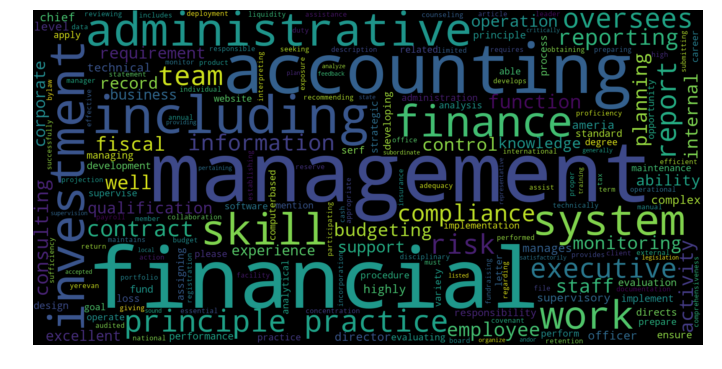

In [44]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(df['token_jobpost'][0])
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Classification

In [46]:
X = df.token_jobpost
y = df.IT

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=123)

In [48]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df.token_jobpost)
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

print(Tfidf_vect.vocabulary_)

{'ameria': 1174, 'investment': 14063, 'consulting': 5702, 'chief': 4565, 'financial': 10251, 'officer': 18800, 'yerevan': 29725, 'description': 7216, 'seeking': 24021, 'manages': 16240, 'fiscal': 10345, 'administrative': 534, 'function': 10972, 'provides': 21560, 'highly': 12246, 'responsible': 22926, 'technically': 26569, 'complex': 5337, 'staff': 25396, 'assistance': 2277, 'executive': 9580, 'director': 7614, 'work': 29444, 'performed': 19958, 'requires': 22790, 'high': 12210, 'level': 15442, 'technical': 26561, 'proficiency': 21289, 'management': 16178, 'well': 29174, 'supervisory': 26054, 'skill': 24739, 'responsibility': 22923, 'supervises': 26044, 'including': 13235, 'assigning': 2266, 'reviewing': 23069, 'employee': 8777, 'process': 21196, 'product': 21239, 'counseling': 6091, 'giving': 11395, 'performance': 19948, 'evaluation': 9429, 'recommending': 22221, 'disciplinary': 7667, 'action': 358, 'serf': 24253, 'member': 16759, 'team': 26518, 'participating': 19652, 'strategic': 25

#### Models

#### SVM

In [52]:
svc  = svm.SVC()
svc.fit(Train_X_Tfidf,y_train)

predictions_SVC = svc.predict(Test_X_Tfidf)
predictions_SVC_train = svc.predict(Train_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions_SVC))

print("")
print("The accuracy score for test prediction is : {}".format(metrics.accuracy_score(predictions_SVC, y_test)))
print("The precision score for test prediction is : {}".format(metrics.precision_score(predictions_SVC, y_test)))
print("The f1_score for test prediction is : {}".format(metrics.f1_score(predictions_SVC, y_test)))
print("")

print("")
print("The accuracy score for train prediction is : {}".format(metrics.accuracy_score(predictions_SVC_train, y_train)))
print("The precision score for train prediction is : {}".format(metrics.precision_score(predictions_SVC_train, y_train)))
print("The f1_score for train prediction is : {}".format(metrics.f1_score(predictions_SVC_train, y_train)))
print("")

Confusion matrix:
[[4505    0]
 [1163    0]]

The accuracy score for test prediction is : 0.7948129851799577
The precision score for test prediction is : 0.0
The f1_score for test prediction is : 0.0


The accuracy score for train prediction is : 0.8045220810647308
The precision score for train prediction is : 0.0
The f1_score for train prediction is : 0.0



C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


#### Naive Bayes

In [53]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_NB_train = Naive.predict(Train_X_Tfidf)
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions_NB))

print("")
print("The accuracy score for test prediction is : {}".format(metrics.accuracy_score(predictions_NB, y_test)))
print("The precision score for test prediction is : {}".format(metrics.precision_score(predictions_NB, y_test)))
print("The f1_score for test prediction is : {}".format(metrics.f1_score(predictions_NB, y_test)))
print("")

print("")
print("The accuracy score for train prediction is : {}".format(metrics.accuracy_score(predictions_NB_train, y_train)))
print("The precision score for train prediction is : {}".format(metrics.precision_score(predictions_NB_train, y_train)))
print("The f1_score for train prediction is : {}".format(metrics.f1_score(predictions_NB_train, y_train)))
print("")

Confusion matrix:
[[4402  103]
 [ 379  784]]

The accuracy score for test prediction is : 0.9149611856033875
The precision score for test prediction is : 0.6741186586414445
The f1_score for test prediction is : 0.7648780487804877


The accuracy score for train prediction is : 0.9212794918330308
The precision score for train prediction is : 0.6928433268858801
The f1_score for train prediction is : 0.7748215444516549



#### Logistic Regression

In [55]:
logit = LogisticRegression()
logit.fit(Train_X_Tfidf,y_train)
predictions = logit.predict(Test_X_Tfidf)
prediction_train = logit.predict(Train_X_Tfidf)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for train prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for train prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for train prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for test prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for test prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for test prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[4420   85]
 [ 272  891]]

The accuracy score for train prediction is : 0.9510738052026618
The precision score for train prediction is : 0.8154738878143133
The f1_score for train prediction is : 0.8669545548015628

The accuracy score for test prediction is : 0.9370148200423429
The precision score for test prediction is : 0.766122098022356
The f1_score for test prediction is : 0.8330995792426367


#### K-Means Clustering

In [57]:
df['token_RequiredQual'] = df['RequiredQual'].apply(lambda x: nltk.tokenize.WhitespaceTokenizer().tokenize(x))
df['token_RequiredQual'].head()

0    [perform, job, successfully, individual, must,...
1    [bachelors, degree, masters, preferred, excell...
2    [degree, environmentally, related, field, year...
3    [advanced, degree, public, health, social, sci...
4    [university, degree, economical, background, p...
Name: token_RequiredQual, dtype: object

In [58]:
df['token_RequiredQual'] = df['token_RequiredQual'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df['token_RequiredQual'].head()

0    [perform, job, successfully, individual, must,...
1    [bachelor, degree, master, preferred, excellen...
2    [degree, environmentally, related, field, year...
3    [advanced, degree, public, health, social, sci...
4    [university, degree, economical, background, p...
Name: token_RequiredQual, dtype: object

In [59]:
df['token_RequiredQual'] = df['token_RequiredQual'].apply(lambda x: [y for y in x if y not in new_stopwords])
df['token_RequiredQual'] = df['token_RequiredQual'].apply(lambda x: ' '.join(x))
df['token_RequiredQual'].head()

0    perform successfully individual must able perf...
1    bachelor degree master preferred excellent ski...
2    degree environmentally related field year rele...
3    advanced degree public health social science c...
4    university degree economical background plus e...
Name: token_RequiredQual, dtype: object

In [60]:
Tfidf_vect = TfidfVectorizer(max_df=0.7,min_df=3)
Tfidf_vect.fit(df.token_RequiredQual)
Tfidf_RequiredQual = Tfidf_vect.transform(df.token_RequiredQual)

In [61]:
len(Tfidf_vect.get_feature_names())

6078

#### SVD Decomposition

Derive 1500 new features out of 6078 features.

In [64]:
Tsvd = TruncatedSVD(n_components=1500)
reduced_data = Tsvd.fit_transform(Tfidf_RequiredQual)

In [65]:
feature_names = Tfidf_vect.get_feature_names()

In [66]:
best_features = [feature_names[i] for i in Tsvd.components_[0].argsort()[::-1]]
best_features = best_features[:1500]

In [69]:
print(Tsvd.explained_variance_ratio_.sum())

0.8859899342404942


In [72]:
# calculate SC for K=4 through K=10
k_range = range(4, 10)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(reduced_data)
    scores.append(metrics.silhouette_score(reduced_data, km.labels_))

#### Silhoutte Score

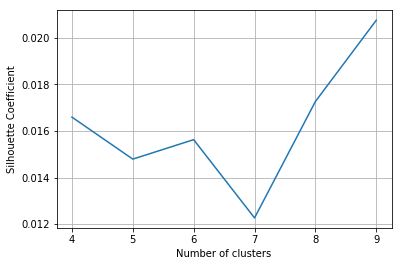

In [73]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

Clearly, at K=6, SC is the highest

Final K-Means model with K=6

In [74]:
kmodel = KMeans(n_clusters=6, random_state=123)
kmodel.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

Examining top words in each cluster

In [75]:
prediction = kmodel.predict(reduced_data)

In [76]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = Tfidf_vect.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(Tfidf_RequiredQual.toarray(), prediction, 15)

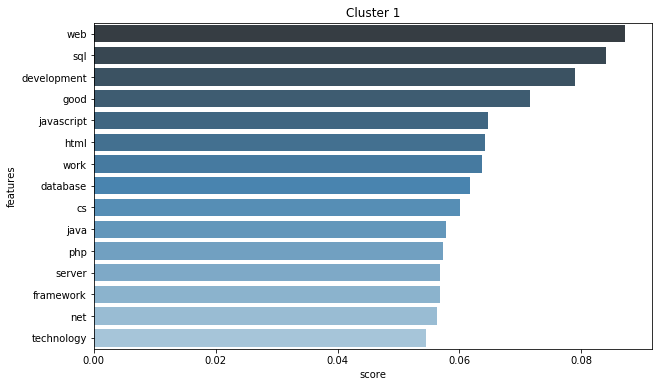

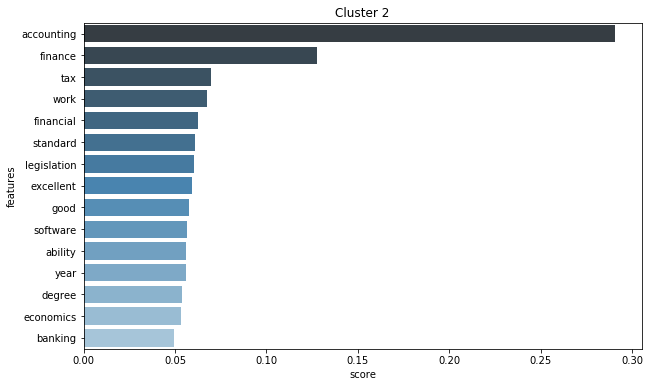

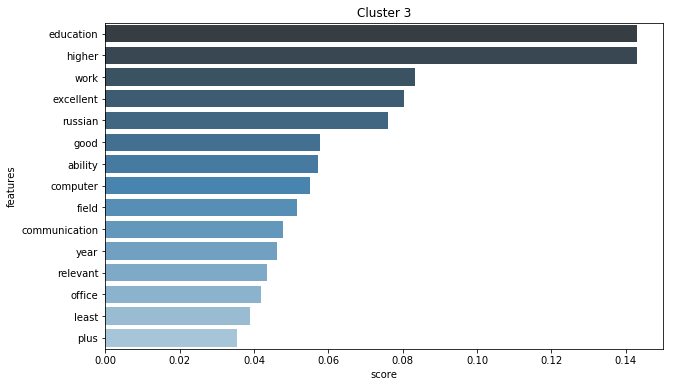

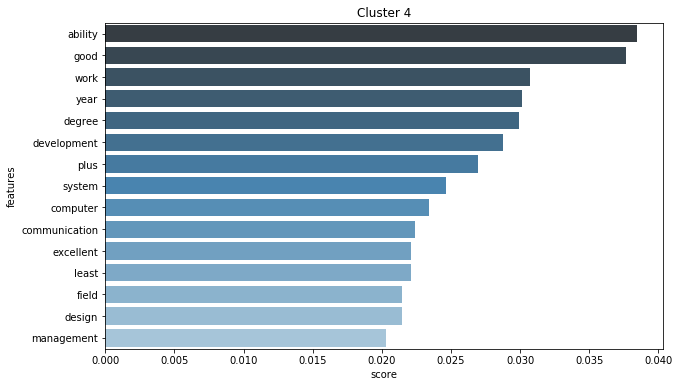

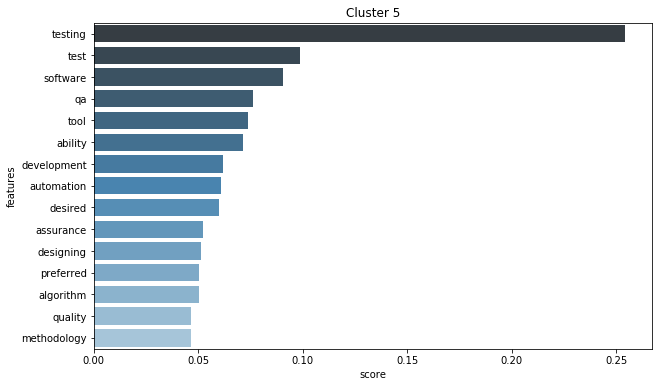

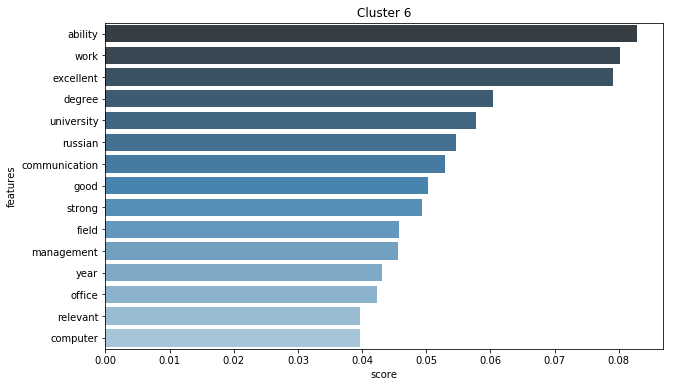

In [77]:
for i in range(1,len(dfs) + 1):
    f,ax = plt.subplots(figsize=(10,6))
#     sns.set_color_codes("muted")
    sns.barplot(x="score", y="features", data=pd.DataFrame(dfs[i-1]),
                palette="Blues_d")
    title = 'Cluster ' + str(i)
    plt.title(title)
    plt.show()

#### Cluster Profiling

#### Named Entity Recognition

In [79]:
nlp = en_core_web_sm.load()

In [80]:
doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
print([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'), ('Google', 'ORG'), ('$5.1 billion', 'MONEY'), ('Wednesday', 'DATE')]


In [82]:
displacy.render(nlp(str(doc)), jupyter=True, style='ent')

In [84]:
org_words = []
for row in df.token_RequiredQual.iteritems():
    doc = nlp(row[1])
    arr =  [x for x in doc.ents if x.label_ == 'ORG']
    for i in arr:
        org_words.append(str(i))

In [86]:
org_cloud = list(set(org_words))
org_cloud = ' '.join(org_cloud)

#### WordCloud

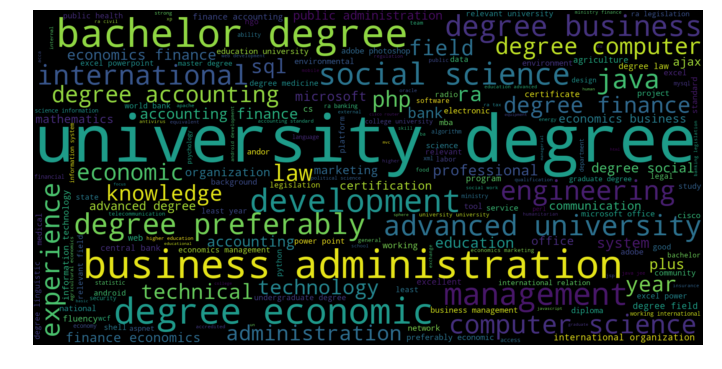

In [87]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(org_cloud)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Topic Modelling

In [90]:
df['token_jobpost'] = df['token_jobpost'].apply(lambda x: nltk.tokenize.WhitespaceTokenizer().tokenize(x))
id2word = corpora.Dictionary(df.token_jobpost)

In [91]:
texts = df.token_jobpost
corpus = [id2word.doc2bow(text) for text in texts]

In [92]:
print(corpus[:1])

[[(0, 3), (1, 2), (2, 1), (3, 1), (4, 11), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 2), (11, 7), (12, 2), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 3), (32, 3), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 4), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 3), (58, 1), (59, 4), (60, 3), (61, 3), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 2), (79, 2), (80, 1), (81, 1), (82, 2), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 3), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 2), (99, 2), (100, 3), (101, 4), (102, 3), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [93]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 3),
  ('able', 2),
  ('acca', 1),
  ('accepted', 1),
  ('accounting', 11),
  ('achieve', 1),
  ('action', 1),
  ('activity', 3),
  ('addressing', 1),
  ('adequacy', 1),
  ('administration', 2),
  ('administrative', 7),
  ('ameria', 2),
  ('analysis', 2),
  ('analytical', 2),
  ('analyze', 1),
  ('andor', 1),
  ('annual', 1),
  ('apply', 2),
  ('appropriate', 1),
  ('article', 1),
  ('assigning', 2),
  ('assist', 1),
  ('assistance', 1),
  ('assistant', 1),
  ('attracting', 1),
  ('audience', 1),
  ('audited', 1),
  ('banking', 1),
  ('board', 1),
  ('budget', 1),
  ('budgeting', 3),
  ('business', 3),
  ('bylaw', 1),
  ('candidate', 1),
  ('career', 2),
  ('careercenteram', 1),
  ('cash', 1),
  ('center', 1),
  ('ceo', 1),
  ('certification', 1),
  ('cfa', 1),
  ('cfo', 1),
  ('change', 1),
  ('chief', 2),
  ('clearly', 1),
  ('client', 1),
  ('closely', 1),
  ('collaboration', 1),
  ('communication', 1),
  ('complex', 2),
  ('compliance', 4),
  ('comprehensive', 1),
  ('

#### LDA Model

In [94]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [95]:
lda_model.print_topics()

[(0,
  '0.017*"english" + 0.017*"language" + 0.013*"center" + 0.011*"career" + 0.011*"announcement" + 0.010*"course" + 0.010*"please" + 0.009*"office" + 0.009*"website" + 0.009*"opportunity"'),
 (1,
  '0.029*"project" + 0.016*"development" + 0.010*"program" + 0.010*"activity" + 0.009*"support" + 0.009*"management" + 0.008*"implementation" + 0.008*"experience" + 0.007*"work" + 0.007*"ensure"'),
 (2,
  '0.022*"experience" + 0.016*"knowledge" + 0.016*"software" + 0.016*"development" + 0.013*"design" + 0.011*"team" + 0.010*"please" + 0.010*"website" + 0.010*"mention" + 0.010*"opportunity"'),
 (3,
  '0.019*"mention" + 0.017*"website" + 0.017*"please" + 0.017*"opportunity" + 0.017*"skill" + 0.014*"candidate" + 0.013*"knowledge" + 0.013*"work" + 0.011*"language" + 0.010*"organization"'),
 (4,
  '0.027*"marketing" + 0.021*"medium" + 0.014*"online" + 0.013*"content" + 0.012*"event" + 0.012*"creative" + 0.011*"social" + 0.010*"communication" + 0.009*"research" + 0.009*"material"'),
 (5,
  '0.019

#### Topic Models

#### Visualize topics

In [97]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.140847  0.065738       1        1  39.459274
1     -0.017729 -0.129225       2        1  19.866592
2     -0.097741  0.035660       3        1  16.954786
5     -0.087149 -0.241726       4        1  11.698841
0     -0.069704  0.252621       5        1   8.215903
4      0.413170  0.016932       6        1   3.804603, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
430    Default  25858.000000        project  25858.000000  30.0000  30.0000
1281   Default   7778.000000      marketing   7778.000000  29.0000  29.0000
79     Default  25229.000000    development  25229.000000  28.0000  28.0000
344    Default  28107.000000       language  28107.000000  27.0000  27.0000
112    Default   9457.000000      financial   9457.000000  26.0000  26.0000
93     Default  21985.000000        english  21985.000000  25.0000  25.0000
252    Default  12585.000000       software  12585.000000  24.0000  24.0000
2037   Default   7377.000000           bank   7377.000000  23.0000  23.0000
4      Default   7196.000000     accounting   7196.000000  22.0000  22.0000
102    Default  38917.000000     experience  38917.000000  21.0000  21.0000
38     Default  22864.000000         center  22864.000000  20.0000  20.0000
197    Default  39162.000000         please  39162.000000  19.0000  19.0000
75     Default  10576.000000         design  10576.000000  18.0000  18.0000
35     Default  20226.000000         career  20226.000000  17.0000  17.0000
227    Default  12692.000000         report  12692.000000  16.0000  16.0000
145    Default  38643.000000      knowledge  38643.000000  15.0000  15.0000
49     Default  15732.000000  communication  15732.000000  14.0000  14.0000
159    Default  17923.000000     management  17923.000000  13.0000  13.0000
275    Default  12375.000000         system  12375.000000  12.0000  12.0000
94     Default  12811.000000         ensure  12811.000000  11.0000  11.0000
293    Default  38870.000000        website  38870.000000  10.0000  10.0000
575    Default   6019.000000      developer   6019.000000   9.0000   9.0000
729    Default  22004.000000   announcement  22004.000000   8.0000   8.0000
176    Default  13369.000000         office  13369.000000   7.0000   7.0000
814    Default   5158.000000          legal   5158.000000   6.0000   6.0000
1282   Default   3158.000000         medium   3158.000000   5.0000   5.0000
181    Default  38964.000000    opportunity  38964.000000   4.0000   4.0000
166    Default  39971.000000        mention  39971.000000   3.0000   3.0000
485    Default  10942.000000        develop  10942.000000   2.0000   2.0000
278    Default  17963.000000           team  17963.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
1887    Topic6    268.447235        germany    269.226715   3.2661  -6.3435
414     Topic6    254.265442        georgia    255.038742   3.2659  -6.3978
1591    Topic6   2065.597900         online   2136.356445   3.2353  -4.3030
28243   Topic6    432.297607      citymobil    437.864594   3.2562  -5.8670
896     Topic6   1333.666870         europe   1405.823120   3.2163  -4.7404
660     Topic6   1004.148315       campaign   1090.679688   3.1863  -5.0242
3303    Topic6    720.205444           page    783.365845   3.1849  -5.3566
1552    Topic6    512.506653          story    550.770935   3.1970  -5.6968
929     Topic6   1756.717041       creative   2334.211914   2.9847  -4.4649
1281    Topic6   4157.780273      marketing   7778.639648   2.6426  -3.6034
325     Topic6   1828.195557          event   2900.444580   2.8074  -4.4250
940     Topic6    406.487885      important    438.779236   3.1925  -5.9286
549     Topic6   1670.928589         social   3849.955566   2.4343  -4.5150
1088    Topic6    876.369202 

#### Job Similarity

In [99]:
df['token_JobRequirment'] = df['JobRequirment'].apply(lambda x: nltk.tokenize.WhitespaceTokenizer().tokenize(x))
df['token_JobDescription'] = df['JobDescription'].apply(lambda x: nltk.tokenize.WhitespaceTokenizer().tokenize(x))

In [100]:
df['token_JobRequirment'] = df['token_JobRequirment'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df['token_JobDescription'] = df['token_JobDescription'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [101]:
df['token_JobRequirment'] = df['token_JobRequirment'].apply(lambda x: [y for y in x if y not in new_stopwords])
df['token_JobRequirment'] = df['token_JobRequirment'].apply(lambda x: ' '.join(x))
df['token_JobDescription'] = df['token_JobDescription'].apply(lambda x: [y for y in x if y not in new_stopwords])
df['token_JobDescription'] = df['token_JobDescription'].apply(lambda x: ' '.join(x))

In [123]:
# corpus =pd.concat([df.question1,df.question2])
tf = TfidfVectorizer().fit(df['token_JobRequirment'])
a = tf.transform([df.iloc[0]['token_JobRequirment']])
b = tf.transform([df.iloc[2]['token_JobRequirment']])
cosine_similarity(a,b).ravel()[0]

0.029243163285821633

#### Cosine Similarity

In [183]:
def cosine_function(title,col):
    acc_df = df[df['Title'] == title]
    cosn = []
    for i in range(0,acc_df.shape[0]):
        avg = []
        for j in range(0,acc_df.shape[0]):
            if i != j:
                a = tf.transform([acc_df.iloc[i][col]])
                b = tf.transform([acc_df.iloc[j][col]])
                avg.append(cosine_similarity(a,b).ravel()[0])
        cosn.append(sum(avg)/len(avg))
    return cosn

In [184]:
jobReq_arr = cosine_function('chief financial officer','token_JobRequirment')
jobDesc_arr = cosine_function('chief financial officer','token_JobDescription')
reqQual_arr = cosine_function('chief financial officer','token_RequiredQual')

In [185]:
acc_cosn_score = []
for i,j,k in zip(jobReq_arr,jobDesc_arr,reqQual_arr):
    acc_cosn_score.append((i+j+k)/3)

In [190]:
acc_df = df[df['Title'] == 'chief financial officer'].reset_index()
acc_df['Similarity_Score'] = pd.Series(acc_cosn_score)
acc_df = acc_df.sort_values(by=['Similarity_Score'],ascending=False)[['Title','JobRequirment','JobDescription','RequiredQual','Similarity_Score']].head(10)

In [192]:
acc_df.style.set_properties(subset=['Title','JobRequirment','JobDescription','RequiredQual','Similarity_Score'], **{'width': '200px'})